# Advertisement Detection using Audio Matching

Find all instances of an audio advertisements in an longer audio clip.

This is an answer for a [question on Stack Overflow](https://stackoverflow.com/questions/75961430/how-to-find-out-how-many-times-a-specific-audio-repeats-in-another-longer-audio?noredirect=1#comment133991665_75961430).

The detection is done using an *audio matching* technique, called [DiagonalMatching](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C7/C7S2_DiagonalMatching.html) from the book [Fundamentals of Music Processing
Using Python and Jupyter Notebooks](https://www.audiolabs-erlangen.de/fau/professor/mueller/bookFMP) (FMP) by Meinard Müller.

Some functions are reused from there.
There are also some differences. In particular, the feature representation is different. As the FMP example has a feature-set that is specific to music.

NOTE: This approach assumes that the audio clip being queried for is very similar each time it appears.
If there is variations in the clip or it or occurs together with other sounds et.c, it will probably not work well.

The operating principle is Euclidean distance in the feature space. Matches should then have a very low distance, compared to other audio. 
This is conceptually similar to cross-correlation.


In [5]:
import math

import numpy
import pandas
import librosa

import seaborn
from matplotlib import pyplot as plt

np = numpy # code from FMP uses this

In [7]:
def normalize_feature_sequence(X, norm='2', threshold=0.0001, v=None):
    """Normalizes the columns of a feature sequence

    Notebook: C3/C3S1_FeatureNormalization.ipynb

    Args:
        X (np.ndarray): Feature sequence
        norm (str): The norm to be applied. '1', '2', 'max' or 'z' (Default value = '2')
        threshold (float): An threshold below which the vector ``v`` used instead of normalization
            (Default value = 0.0001)
        v (float): Used instead of normalization below ``threshold``. If None, uses unit vector for given norm
            (Default value = None)

    Returns:
        X_norm (np.ndarray): Normalized feature sequence
    """
    assert norm in ['1', '2', 'max', 'z']

    K, N = X.shape
    X_norm = np.zeros((K, N))

    if norm == '2':
        if v is None:
            v = np.ones(K, dtype=np.float64) / np.sqrt(K)
        for n in range(N):
            s = np.sqrt(np.sum(X[:, n] ** 2))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v
    else:
        raise ValueError("Norm type not supported")

    return X_norm

def compute_features(audio, sr, hop_length=512, n_mfcc=13, n_fft=None):
    
    if n_fft is None:
        n_fft = next_power_of_2(hop_length)
    
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc)
    # Normalize using Euclidean norm - as the diagonal matching code expects it
    mfcc = normalize_feature_sequence(mfcc)
    
    return mfcc



match 0: 0:38:26
match 1: 0:03:47
match 2: 0:51:35


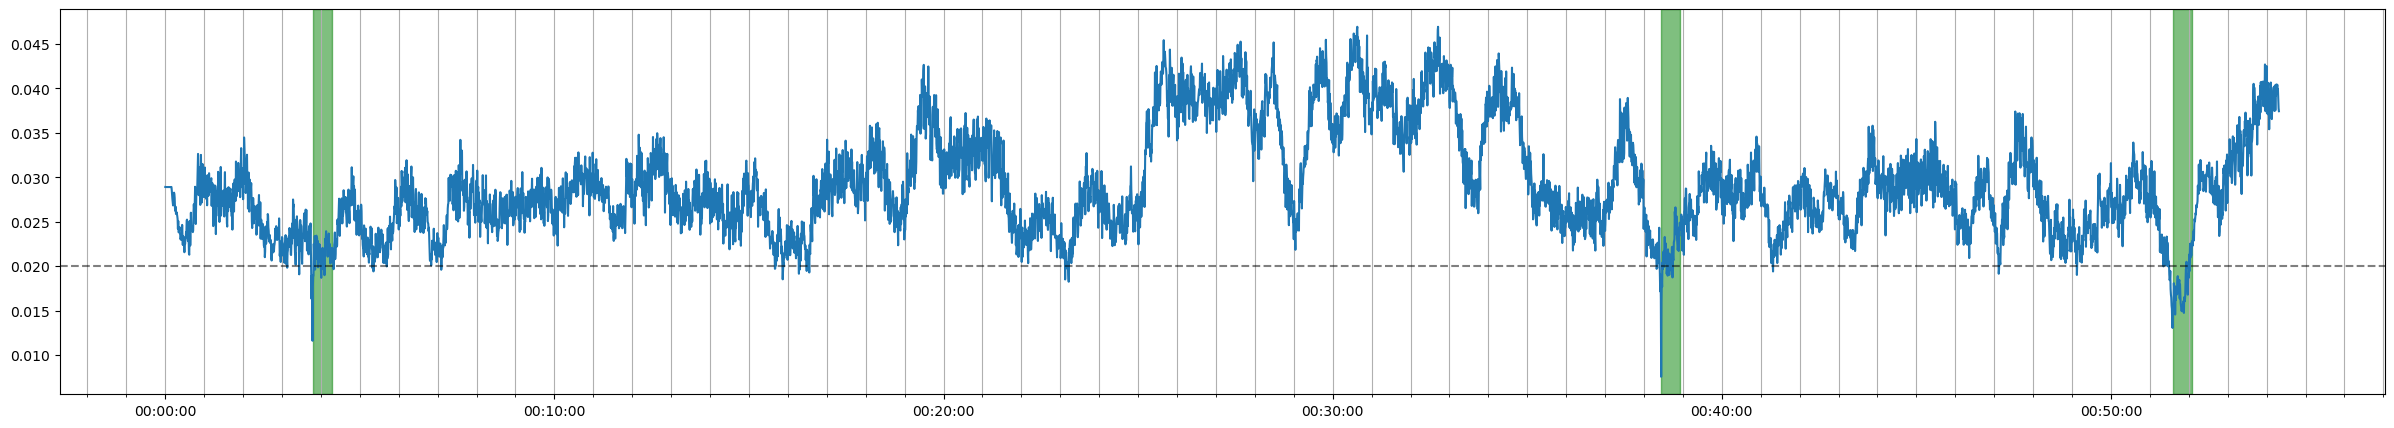

In [88]:

def cost_matrix_dot(X, Y):
    """Computes cost matrix via dot product

    Notebook: C7/C7S2_DiagonalMatching.ipynb

    Args:
        X (np.ndarray): First sequence (K x N matrix)
        Y (np.ndarray): Second sequence (K x M matrix)

    Returns:
        C (np.ndarray): Cost matrix
    """
    return 1 - np.dot(X.T, Y)

def matching_function_diag(C, cyclic=False):
    """Computes diagonal matching function

    Notebook: C7/C7S2_DiagonalMatching.ipynb

    Args:
        C (np.ndarray): Cost matrix
        cyclic (bool): If "True" then matching is done cyclically (Default value = False)

    Returns:
        Delta (np.ndarray): Matching function
    """
    N, M = C.shape
    assert N <= M, "N <= M is required"
    Delta = C[0, :]
    for n in range(1, N):
        Delta = Delta + np.roll(C[n, :], -n)
    Delta = Delta / N
    if cyclic is False:
        Delta[M-N+1:M] = np.inf
    return Delta

def mininma_from_matching_function(Delta, rho=2, tau=0.2, num=None):
    """Derives local minima positions of matching function in an iterative fashion

    Notebook: C7/C7S2_DiagonalMatching.ipynb

    Args:
        Delta (np.ndarray): Matching function
        rho (int): Parameter to exclude neighborhood of a matching position for subsequent matches (Default value = 2)
        tau (float): Threshold for maximum Delta value allowed for matches (Default value = 0.2)
        num (int): Maximum number of matches (Default value = None)

    Returns:
        pos (np.ndarray): Array of local minima
    """
    Delta_tmp = numpy.array(Delta).copy()
    M = len(Delta)
    pos = []
    num_pos = 0
    rho = int(rho)
    if num is None:
        num = M
    while num_pos < num and np.sum(Delta_tmp < tau) > 0:
        m = np.argmin(Delta_tmp)
        #print(Delta_tmp.shape)
        #print('argmin', m, Delta_tmp[int(m)])
        pos.append(m)
        num_pos += 1
        # exclude this region from candidate minimums
        s = max(0, m - rho)
        e = min(m + rho, M)
        #print(s, e)
        Delta_tmp[s:e] = np.inf
    pos = np.array(pos).astype(int)
    return pos

def next_power_of_2(x):
    return 2**(math.ceil(math.log(x, 2)))

def plot_results(scores, threshold=None, events=None):
        
    fig, ax = plt.subplots(1, figsize=(30, 5))
    ax.plot(scores.reset_index()['time'], scores['distance'])

    if threshold is not None:
        ax.axhline(threshold, ls='--', alpha=0.5, color='black')
        
    if events is not None:
        for idx, e in events.iterrows():
            ax.axvspan(e['start'], e['end'], color='green', alpha=0.5)
    
    import matplotlib.ticker
    x_formatter = matplotlib.ticker.FuncFormatter(ticker_format_minutes_seconds)
    ax.xaxis.set_major_formatter(x_formatter)
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=10*60))
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(base=60))
    ax.grid(axis='x')
    ax.grid(axis='x', which='minor')

    return fig
    
def ticker_format_minutes_seconds(x, pos):
    hours = int(x//3600)
    minutes = int((x%3600)//60)
    seconds = int(x%60)

    return "{:02d}:{:02d}:{:02d}".format(hours, minutes, seconds)


def find_audio(long, short, sr=16000, time_resolution=0.500, max_matches=10, score_threshold=0.1):

    # distance between frames in feature representation [seconds]

    hop_length = int(time_resolution*samplerate)
    
    # compute features for the audio
    query = compute_features(short, sr=sr, hop_length=hop_length)
    clip = compute_features(long, sr=sr, hop_length=hop_length)
    

    # Compute cost matrix and matching function
    C = cost_matrix_dot(query, clip)
    Delta = matching_function_diag(C)
    
    scores = pandas.DataFrame({
        'time': librosa.times_like(Delta, hop_length=hop_length, sr=samplerate),
        'distance': Delta,
    }).set_index('time')
    
    # convert to discrete
    match_idx = mininma_from_matching_function(scores['distance'].values,
                                               num=max_matches, rho=query.shape[1], tau=score_threshold)

    matches = scores.reset_index().loc[match_idx]
    matches = matches.rename(columns={'time': 'start'})
    matches['end'] = matches['start'] + (query.shape[1] * time_resolution)
    matches = matches.reset_index()
    
    return scores, matches


# configuration
samplerate = 16000
threshold = 0.02
max_matches = 3 

#short, sr = librosa.load('house_ad.m4a', sr=samplerate)
#long, sr = librosa.load('long_audio.m4a', sr=samplerate)

scores, matches = find_audio(long, short, max_matches=max_matches, score_threshold=threshold)

# print results
for idx, m in matches.iterrows():
    td = pandas.Timedelta(m['start'], unit='s').round('1s').to_pytimedelta()
    print(f'match {idx}: {td}')

# visualize results
fig = plot_results(scores, events=matches, threshold=threshold)
fig.savefig('results.png')
